In [7]:

import torch
import sys
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from data import DAGMDataset
from settings import TRAINING_LABEL_FILE_PATH, TEST_LABEL_FILE_PATH
import matplotlib.pyplot as plt
from torchvision.io import read_image
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
class AEDataset(DAGMDataset):
    def __init__(self, meta_file, transform=None, target_transform=None, defect_only=False):
        super(AEDataset, self).__init__(meta_file,transform,target_transform, defect_only)
        #self.meta_df=self.meta_df[self.meta_df["class"]<=5]

    def __getitem__(self,idx):
        img_path = self.meta_df["img_file"].iloc[idx]
        image = read_image(img_path).float()
        has_defect = self.meta_df["has_defect"].iloc[idx] == 1
        defect_mask_path = str(self.meta_df["label_file"].iloc[idx])
        if self.transform:
            image = self.transform(image)
        if has_defect:
            defect_mask = read_image(defect_mask_path).flatten().float()
        else:
            defect_mask = torch.zeros(512**2, dtype=torch.float)

        defect_mask[defect_mask!=0.]=1
        #defect_mask is a 512**2 binary tensor
        return image.float(), defect_mask.float()



In [9]:
transform = transforms.Normalize((0,), (255,))

batch_size=2
defect_only = True
training_set = AEDataset(meta_file=TRAINING_LABEL_FILE_PATH, transform=transform, defect_only=defect_only)
testing_set = AEDataset(meta_file=TEST_LABEL_FILE_PATH, transform=transform, defect_only=defect_only)
train_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_set, batch_size=batch_size, shuffle=True)

In [10]:
class autoencoder_wasp(nn.Module):
    def __init__(self):
        super(autoencoder_wasp, self).__init__()
        channel=64
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=channel, kernel_size=3,padding=1),
            nn.ReLU(),   
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=channel, out_channels=2*channel, kernel_size=3,padding=1),
            nn.ReLU(),   
        )

        self.layer3 = nn.MaxPool2d(2,2)
        
        coe=2
        self.wasp4=nn.Conv2d(in_channels=channel*2, out_channels=channel*coe, kernel_size=3,padding=4,dilation=4)
        self.wasp4_c1=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=1)
        self.wasp4_c2=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=1)

        self.wasp8=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=3,padding=8,dilation=8)
        self.wasp8_c1=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=1)
        self.wasp8_c2=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=1)

        self.wasp16=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=3,padding=16,dilation=16)
        self.wasp16_c1=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=1)
        self.wasp16_c2=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=1)

        self.wasp32=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=3,padding=32,dilation=32)
        self.wasp32_c1=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=1)
        self.wasp32_c2=nn.Conv2d(in_channels=channel*coe, out_channels=channel*coe, kernel_size=1)

        self.avgpool = nn.Sequential(
            nn.AdaptiveAvgPool2d(256),
            nn.Upsample(size=256)
        )

        self.layer4 = nn.Upsample(scale_factor=2)
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=channel*12, out_channels=channel, kernel_size=3,padding=1),
            nn.ReLU(),   
        )


        self.layerfinal = nn.Sequential(
            nn.Conv2d(in_channels=channel, out_channels=2, kernel_size=1),
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        y=self.layer1(x)
        y=self.layer2(y)
        y2=y
        y=self.layer3(y)

        _res4=self.wasp4(y)
        res4=self.wasp4_c1(_res4)
        res4=self.wasp4_c2(res4)

        _res8=self.wasp8(_res4)
        res8=self.wasp8_c1(_res8)
        res8=self.wasp8_c2(res8)

        _res16=self.wasp16(_res8)
        res16=self.wasp16_c1(_res16)
        res16=self.wasp16_c2(res16)

        _res32=self.wasp32(_res16)
        res32=self.wasp32_c1(_res32)
        res32=self.wasp32_c2(res32)

        
        avg = self.avgpool(y)
        #print(avg.shape,res4.shape,res8.shape,res16.shape,res32.shape)
        y=torch.cat((avg,res4,res8,res16,res32),1)
        y=self.layer4(y)
        y=torch.cat((y,y2),1)
        y=self.layer5(y)
        y=self.layerfinal(y)
        y=self.softmax(y)
        y = torch.flatten(y,2)
        return y[:,0]
    
        
    
    def learn(self,train_loader,optimizer,loss_fcn,epochs=30):
        train_loss_list = []
        for epoch in tqdm(range(epochs)):
            train_loss = 0.
            for i,(image, defect_mask) in enumerate(tqdm(train_loader)):
                image = image.to(device)
                defect_mask = defect_mask.to(device)
                output = self(image)
                loss = loss_fcn(output, defect_mask)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                #print(loss.item())
            train_loss = train_loss / len(train_loader)
            print("train_loss", train_loss)
            train_loss_list.append(train_loss)

In [11]:
class pixel_wise_ce_loss(nn.Module):
    def __init__(self):
        super(pixel_wise_ce_loss, self).__init__()

    def forward(self,output,defect_mask):
        output = torch.clamp(output,min=1e-7,max=1-1e-7)
        loss =  -0.8* defect_mask * torch.log(output) - 0.2*(1 - defect_mask)*torch.log(1 - output)
        return torch.mean(loss)

In [12]:
ae1 = autoencoder_wasp().to(device)
#loss_fcn = nn.BCELoss()
loss_fcn = pixel_wise_ce_loss()
learning_rate = 0.0001

optimizer = torch.optim.Adam(ae1.parameters(),lr=learning_rate,amsgrad=True )
ae1.learn(train_dataloader,optimizer,loss_fcn,epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.04955819367685101


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.03846840297972614


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.03754414194686846


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.03611394317086899


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.03521889062937011


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.03194589399252877


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.02937084251563206


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.025071940786967225


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.01961616143429031


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.016485136044635015


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.015838693993194312


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.01613128266762942


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.014631818373207792


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.013924553090791133


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.012957170475133215


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.011950148668168395


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.01274356301380039


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.011303395267477203


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.011090146201295835


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.010524346918276879


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.010943577136265847


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.010095638619862835


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.01011467620088352


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.00936889402907003


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.00883259839611128


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.008497565437926713


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.008728468612499648


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.009393283349433632


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.008384162648298749


  0%|          | 0/66 [00:00<?, ?it/s]

train_loss 0.00807554084652414


In [13]:
def draw(img):
    with torch.no_grad():
        plt.imshow(img.cpu().numpy().reshape((512,512)), cmap='gray');
        plt.axis('off');

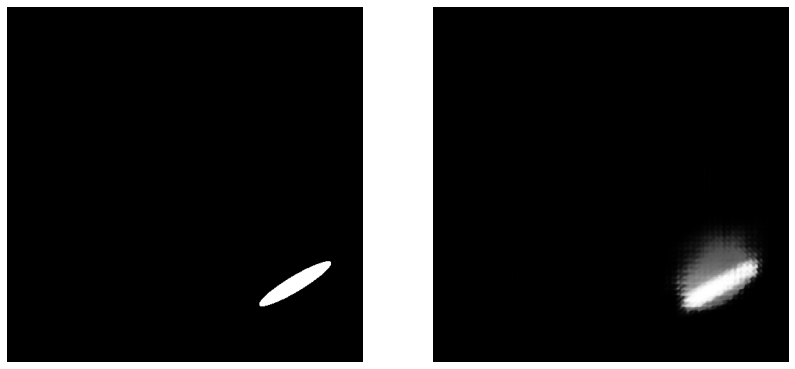

In [43]:
with torch.no_grad():
    plt.figure(figsize=(14,7))
    ae1.to(device)
    image, defect_mask = next(iter(test_dataloader))
    defect_mask=defect_mask.to(device)
    image = image.to(device)
    output = ae1(image)
    plt.subplot(1,2,1); draw(defect_mask[0]);
    plt.subplot(1,2,2); draw(output[0]);


In [15]:
torch.save(ae1.state_dict(), 'ae_wasp.pt')